# Dimensionality Reduction and Data Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
output_dir = "/content/drive/Shareddrives/Labs CompBioMed/results" # Change accordingly
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import zipfile

zip_path = "/content/drive/Shareddrives/Labs CompBioMed/data.zip" # Change accordingly

# Local directory to extract into
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

# Unzip safely
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 97.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

## 1. Metadata Cleaning for Analysis

In [ ]:
base_dir = "/content/data/data"
csv_path = os.path.join(base_dir, "ptbxl_database.csv")
record_dir = os.path.join(base_dir, "records100")

In [ ]:
# Load metadata
variables = pd.read_csv(csv_path, index_col=0)

# Find all .dat files from records100 with the raw ECG signals
files = glob.glob(os.path.join(record_dir, "**", "*.dat"), recursive=True)

# Extract ecg_id from filenames
labels = [os.path.splitext(os.path.basename(f))[0] for f in files]
ecg_ids = [int(label.split("_")[0]) for label in labels]

# Filter metadata to keep only rows for which we have actual ECG waveform files
variables = variables.loc[variables.index.isin(ecg_ids)]

# Reorder filtered metadata to match the order of the waveform files
ordered_indices = [id for id in ecg_ids if id in variables.index]
variables = variables.loc[ordered_indices]

In [ ]:
# Shape and preview
print("Shape of variables:", variables.shape) # Rows are ECGs and columns are metadata
variables.head()

Shape of variables: (21799, 27)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
2698,11619.0,31.0,1,NaN,64.0,0.0,0.0,CS-12 E,1989-04-15 11:21:12,sinusrhythmus lagetyp normal normales ekg,...,True,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/02000/02698_lr,records500/02000/02698_hr
2067,11843.0,61.0,0,NaN,NaN,1.0,2.0,CS-12,1988-08-04 12:43:36,sinusrhythmus lagetyp normal unvollstÄndiger r...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/02000/02067_lr,records500/02000/02067_hr
2549,21158.0,77.0,0,NaN,NaN,NaN,3.0,AT-6 C,1989-03-02 08:10:49,fÖrmaksflimmer/-fladder vÄnster el-axel st-t s...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/02000/02549_lr,records500/02000/02549_hr
2179,4639.0,56.0,0,166.0,58.0,4.0,1.0,AT-6 C 5.5,1988-09-05 05:48:33,sinus rhythm. voltages are high in chest leads...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/02000/02179_lr,records500/02000/02179_hr
2940,17501.0,74.0,0,NaN,NaN,1.0,2.0,CS-12,1989-06-18 15:12:53,sinusrhythmus linkstyp linksschenkelblock,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/02000/02940_lr,records500/02000/02940_hr


In [ ]:
# Identify columns with more than 70% missing values
missing_percentages = (variables.isnull().sum() / len(variables)) * 100
high_missing_cols = missing_percentages[missing_percentages > 70].index.tolist()

# Define additional low-relevance columns to drop manually
additional_cols_to_drop = ['nurse', 'site', 'device', 'recording_date', 'validated_by', 'validated_by_human', 'heart_axis', 'initial_autogenerated_report', 'report', 'second_opinion']

# Combine both lists of columns to drop
cols_to_drop = high_missing_cols + additional_cols_to_drop

# Print columns to be dropped
print("Columns being dropped due to missing or low relevance:")
print("-" * 50)
for col in cols_to_drop:
    if col in variables.columns:
        print(f"{col}: {missing_percentages.get(col, 0):.2f}% missing")

# Drop the identified columns
variables_cleaned = variables.drop(columns=cols_to_drop)

Columns being dropped due to missing or low relevance:
--------------------------------------------------
infarction_stadium1: 74.26% missing
infarction_stadium2: 99.53% missing
baseline_drift: 92.67% missing
static_noise: 85.05% missing
burst_noise: 97.19% missing
electrodes_problems: 99.86% missing
extra_beats: 91.06% missing
pacemaker: 98.67% missing
nurse: 6.76% missing
site: 0.08% missing
device: 0.00% missing
recording_date: 0.00% missing
validated_by: 43.02% missing
validated_by_human: 0.00% missing
heart_axis: 38.85% missing
initial_autogenerated_report: 0.00% missing
report: 0.00% missing
second_opinion: 0.00% missing


In [ ]:
print("\nMissing values per column:")
print(variables_cleaned.isnull().sum())


Missing values per column:
patient_id         0
age                0
sex                0
height         14825
weight         12378
scp_codes          0
strat_fold         0
filename_lr        0
filename_hr        0
dtype: int64


In [ ]:
print("Sex distribution:\n", variables_cleaned["sex"].value_counts(), "\n")
print("Age summary:\n", variables_cleaned["age"].describe())

Sex distribution:
 sex
0    11354
1    10445
Name: count, dtype: int64 

Age summary:
 count    21799.000000
mean        62.769301
std         32.308813
min          2.000000
25%         50.000000
50%         62.000000
75%         72.000000
max        300.000000
Name: age, dtype: float64


In [ ]:
# Cap age at 89 to avoid misleading outliers
variables_cleaned["age"] = variables_cleaned["age"].apply(lambda x: 89 if x == 300 else x)

## 2. Diagnostic Label Mapping

In [ ]:
from ast import literal_eval

def safe_literal_eval(val):
    if isinstance(val, str):
        return literal_eval(val)
    return val  # Already a dict, no need to convert

variables_cleaned["scp_codes"] = variables_cleaned["scp_codes"].apply(safe_literal_eval)

In [ ]:
# Load statement reference table
scp_df = pd.read_csv(os.path.join(base_dir, "scp_statements.csv"), index_col=0)

scp_df.head(10)

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


In [ ]:
# Keep only rows with a diagnostic_class
scp_diagnostic_map = scp_df[scp_df["diagnostic_class"].notnull()]["diagnostic_class"].to_dict()

# Map each scp_codes dict to diagnostic superclasses
def map_to_superclasses(scp_code_dict):
    return list({scp_diagnostic_map[code] for code in scp_code_dict if code in scp_diagnostic_map})

# Add new column with mapped superclasses
variables_cleaned["diagnostic_superclass_mapped"] = variables_cleaned["scp_codes"].apply(map_to_superclasses)

In [ ]:
# Define the 3 target labels
target_labels = {"NORM", "MI", "STTC"}

# Keep records that have at least one of the target labels
variables_filtered = variables_cleaned[variables_cleaned["diagnostic_superclass_mapped"].apply(lambda x: bool(set(x) & target_labels))]

In [ ]:
variables_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18845 entries, 2698 to 6387
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    18845 non-null  float64
 1   age                           18845 non-null  float64
 2   sex                           18845 non-null  int64  
 3   height                        6031 non-null   float64
 4   weight                        8285 non-null   float64
 5   scp_codes                     18845 non-null  object 
 6   strat_fold                    18845 non-null  int64  
 7   filename_lr                   18845 non-null  object 
 8   filename_hr                   18845 non-null  object 
 9   diagnostic_superclass_mapped  18845 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 1.6+ MB


## 3. Handling Missing Biomarker Values

In [ ]:
# Check missingness patterns for height and weight
height_missing = variables_filtered["height"].isnull()
weight_missing = variables_filtered["weight"].isnull()

# Convert list of labels to a string (e.g. "NORM,MI")
df_missing = variables_filtered[height_missing | weight_missing].copy()
df_missing["diagnostic_group"] = df_missing["diagnostic_superclass_mapped"].apply(lambda x: ",".join(sorted(x)))

# Group by sex and label combination
missing_data_summary = df_missing.groupby(['sex', 'diagnostic_group']).size()

print("\nMissing data summary for height or weight:")
print(missing_data_summary)

# Additional summary by age
missing_data_by_age = variables_filtered[height_missing | weight_missing].groupby('age').size()
print("\nMissing data summary by age:")
print(missing_data_by_age)


Missing data summary for height or weight:
sex  diagnostic_group
0    CD,HYP,MI             70
     CD,HYP,MI,STTC        63
     CD,HYP,STTC           90
     CD,MI                673
     CD,MI,STTC            83
     CD,NORM              148
     CD,STTC              169
     HYP,MI                68
     HYP,MI,STTC          150
     HYP,STTC             299
     MI                  1378
     MI,STTC              240
     NORM                2822
     STTC                 732
1    CD,HYP,MI             16
     CD,HYP,MI,STTC        29
     CD,HYP,NORM            1
     CD,HYP,STTC           38
     CD,MI                299
     CD,MI,STTC            55
     CD,NORM              102
     CD,NORM,STTC           1
     CD,STTC              142
     HYP,MI                55
     HYP,MI,STTC           78
     HYP,STTC             217
     MI                   687
     MI,STTC              163
     NORM                3291
     NORM,STTC              3
     STTC                 846
dtyp

In [ ]:
# Impute missing height and weight with global median
# Create a safe copy to avoid SettingWithCopyWarning
variables_filtered = variables_filtered.copy()

# Now impute safely
variables_filtered.loc[:, "height"] = variables_filtered["height"].fillna(variables_filtered["height"].median())
variables_filtered.loc[:, "weight"] = variables_filtered["weight"].fillna(variables_filtered["weight"].median())

## 4. Label Assignment for Visualization

In [ ]:
# Assign a single dominant diagnostic label per ECG
def get_dominant_superclass(scp_code_dict):
    filtered = {k: v for k, v in scp_code_dict.items() if scp_diagnostic_map.get(k) in target_labels}
    if not filtered:
        return None
    dominant_code = max(filtered.items(), key=lambda x: x[1])[0]
    return scp_diagnostic_map[dominant_code]

# New column for dimensionality reduction (we need only one label)
variables_filtered["dominant_label"] = variables_filtered["scp_codes"].apply(get_dominant_superclass)

# Drop rows where dominant_label couldn't be assigned
variables_filtered = variables_filtered[variables_filtered["dominant_label"].notnull()]

## 5. Dimensionality Reduction

Explained variance ratio: [0.66272429 0.27084513]
Total variance explained by first 2 PCs: 0.9335694242171726
             PC1       PC2
age     0.996012  0.088847
sex     0.001990 -0.014107
height -0.034824  0.303647
weight -0.082117  0.948528


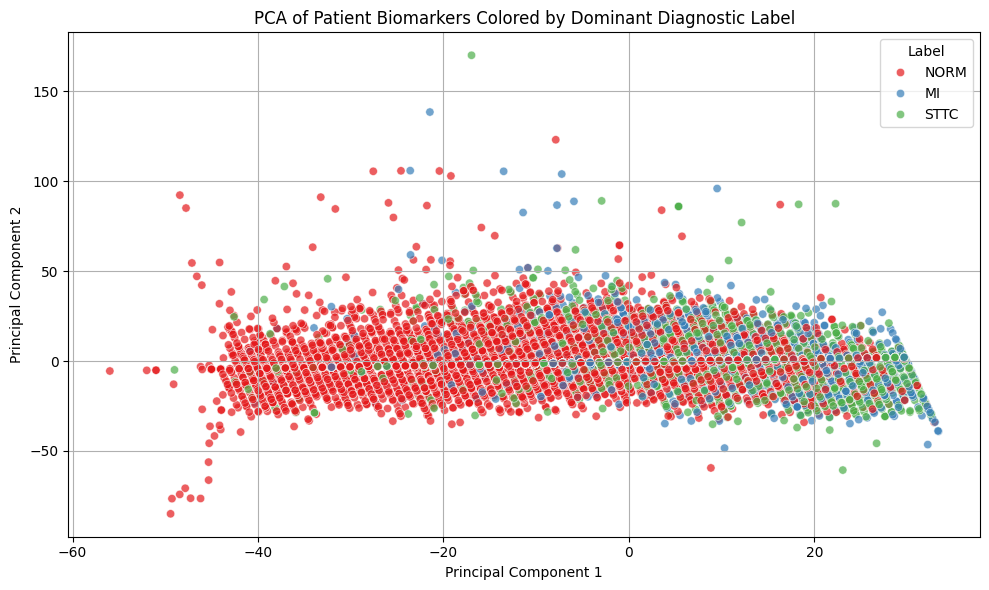

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Features for PCA
features = ["age", "sex", "height", "weight"]
X = variables_filtered[features].values

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained by first 2 PCs:", np.sum(pca.explained_variance_ratio_))

# Add to DataFrame for plotting
variables_filtered["PC1"] = X_pca[:, 0]
variables_filtered["PC2"] = X_pca[:, 1]

loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
print(loadings)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=variables_filtered, x="PC1", y="PC2", hue="dominant_label", palette="Set1", alpha=0.7)
plt.title("PCA of Patient Biomarkers Colored by Dominant Diagnostic Label")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Label")
plt.tight_layout()
pca_plot_path = os.path.join(output_dir, "PCA_Dominant_Label.png")
plt.savefig(pca_plot_path)
plt.show()

<ipython-input-22-3a96926e2a25>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


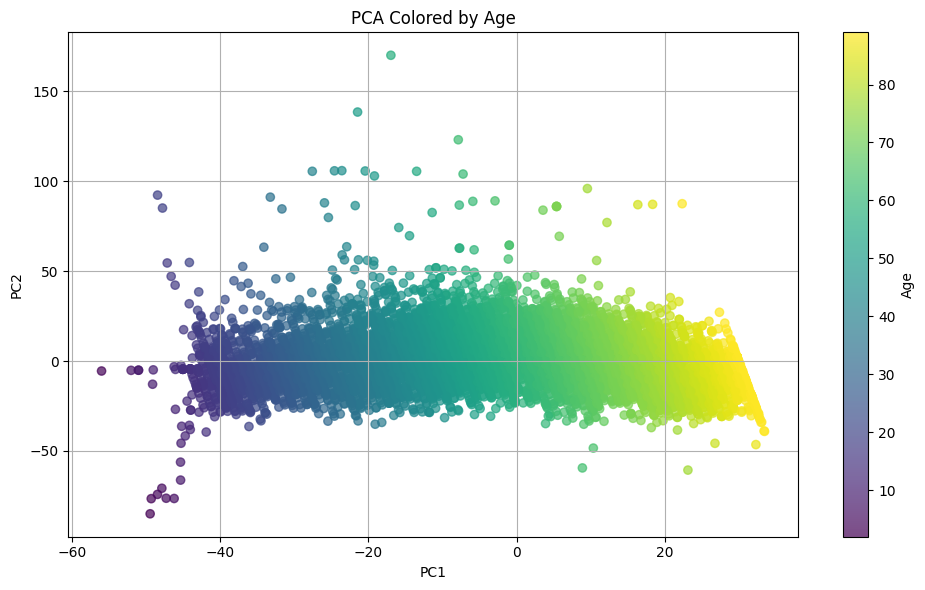

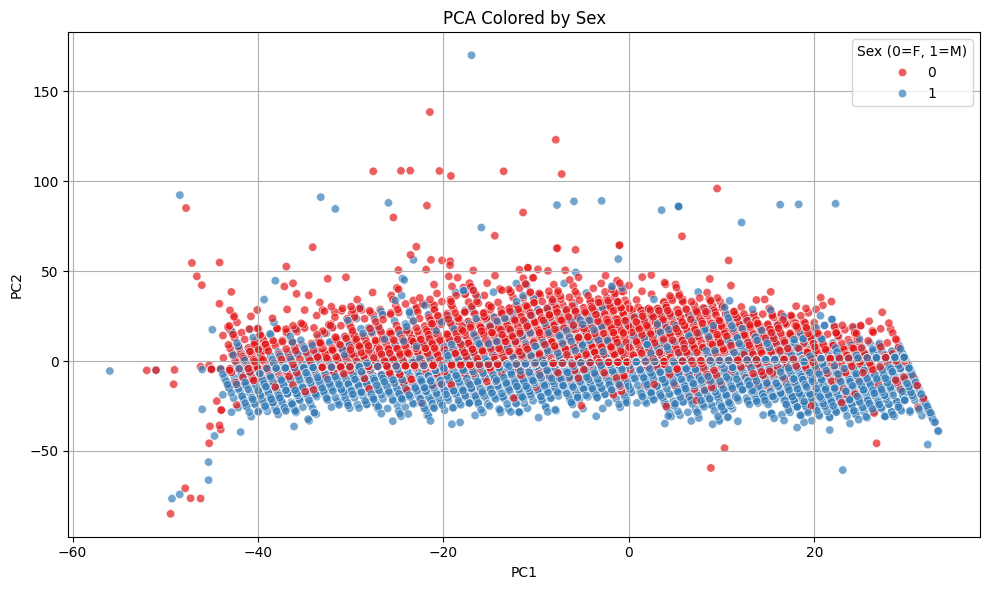

<ipython-input-22-3a96926e2a25>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


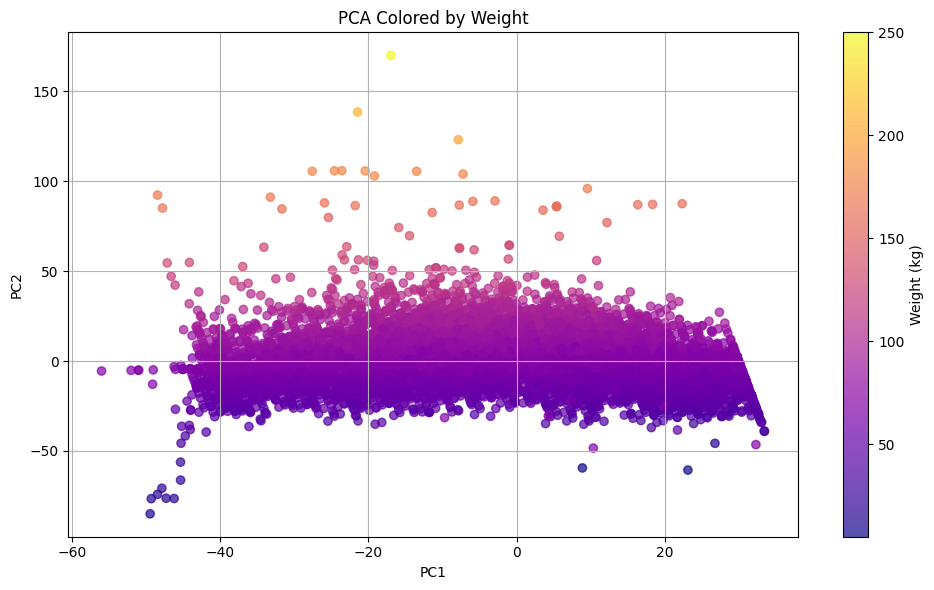

<ipython-input-22-3a96926e2a25>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


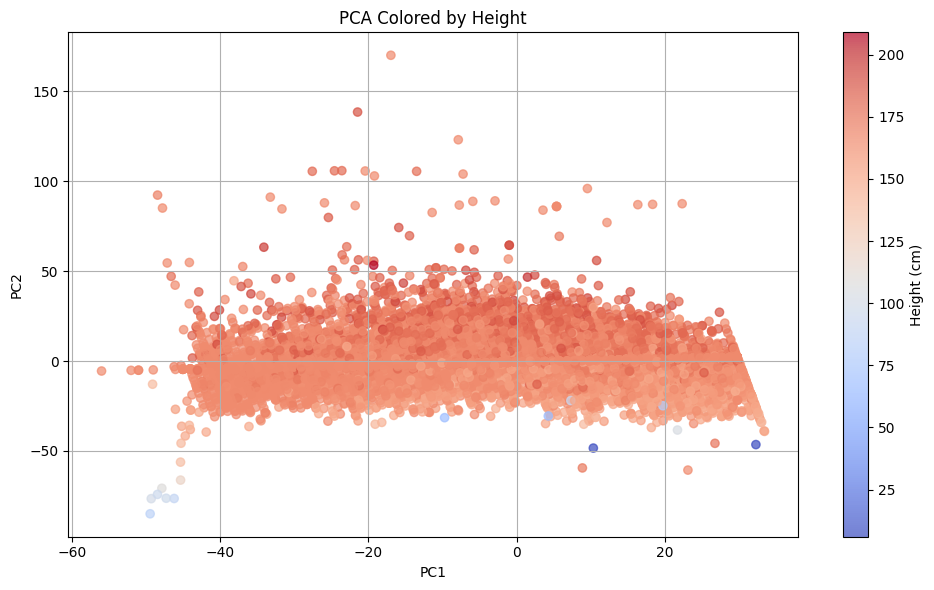

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Age
plt.figure(figsize=(10, 6))
norm = mcolors.Normalize(vmin=variables_filtered["age"].min(), vmax=variables_filtered["age"].max())
cmap = cm.get_cmap("viridis")
sc = plt.scatter(variables_filtered["PC1"], variables_filtered["PC2"],
                 c=variables_filtered["age"], cmap=cmap, norm=norm, alpha=0.7)
plt.colorbar(sc, label="Age")
plt.title("PCA Colored by Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
age_pca_plot_path = os.path.join(output_dir, "PCA_Age.png")
plt.savefig(age_pca_plot_path)
plt.show()

# Sex
plt.figure(figsize=(10, 6))
sns.scatterplot(data=variables_filtered, x="PC1", y="PC2", hue="sex",
                palette="Set1", alpha=0.7)
plt.title("PCA Colored by Sex")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Sex (0=F, 1=M)")
plt.tight_layout()
sex_pca_plot_path = os.path.join(output_dir, "PCA_Sex.png")
plt.savefig(sex_pca_plot_path)
plt.show()

# Weight
plt.figure(figsize=(10, 6))
norm = mcolors.Normalize(vmin=variables_filtered["weight"].min(), vmax=variables_filtered["weight"].max())
cmap = cm.get_cmap("plasma")
sc = plt.scatter(variables_filtered["PC1"], variables_filtered["PC2"],
                 c=variables_filtered["weight"], cmap=cmap, norm=norm, alpha=0.7)
plt.colorbar(sc, label="Weight (kg)")
plt.title("PCA Colored by Weight")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
weight_pca_plot_path = os.path.join(output_dir, "PCA_Weight.png")
plt.savefig(weight_pca_plot_path)
plt.show()

# Height
plt.figure(figsize=(10, 6))
norm = mcolors.Normalize(vmin=variables_filtered["height"].min(), vmax=variables_filtered["height"].max())
cmap = cm.get_cmap("coolwarm")
sc = plt.scatter(variables_filtered["PC1"], variables_filtered["PC2"],
                 c=variables_filtered["height"], cmap=cmap, norm=norm, alpha=0.7)
plt.colorbar(sc, label="Height (cm)")
plt.title("PCA Colored by Height")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
height_pca_plot_path = os.path.join(output_dir, "PCA_Height.png")
plt.savefig(height_pca_plot_path)
plt.show()

## 6. ECG Signal Quality Analysis

In [ ]:
# Signal quality evaluation before training

fs = 100 # Use downsampled signals

# Load ECG signal data
def load_raw_data(df, fs, base_path):
    if fs == 100:
        paths = df["filename_lr"]
    else:
        paths = df["filename_hr"]
    signals = []
    for f in paths:
        full_path = os.path.join(base_path, f)
        signal, _ = wfdb.rdsamp(full_path)
        signals.append(signal)
    return np.array(signals)

# Split data
test_fold = 10
train_df = variables_filtered[variables_filtered["strat_fold"] != test_fold]

# Load ECG training data for analysis
X_signals = load_raw_data(train_df, fs, base_dir)

Lead  SNR (dB)
--------------------
1     14.98          
2     13.35          
3     9.84           
4     14.97          
5     11.41          
6     10.86          
7     14.95          
8     16.16          
9     15.99          
10    16.34          
11    15.48          
12    13.51          


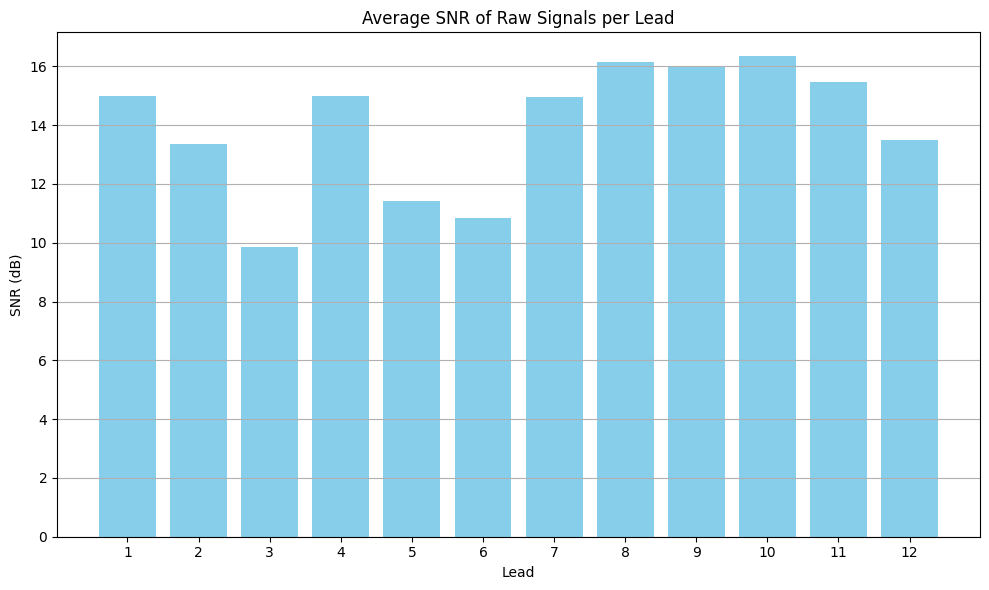

In [ ]:
from scipy import signal

batch_size = 100
num_leads = X_signals.shape[2]

# Function for filtering ECG signal (used for noise estimation)
def apply_filters_with_padding(ecg, fs, pad_len=200):
    ecg_padded = np.pad(ecg, ((pad_len, pad_len), (0, 0)), mode='reflect')

    # High-pass filter (0.5 Hz)
    ecg_padded = signal.filtfilt(*signal.butter(2, 0.5, 'high', fs=fs), ecg_padded, axis=0)

    # Low-pass filter (45 Hz)
    ecg_padded = signal.filtfilt(*signal.butter(2, 45.0, 'low', fs=fs), ecg_padded, axis=0)

    # Remove linear trend
    ecg_padded = signal.detrend(ecg_padded, axis=0)

    # Remove padding
    ecg_filtered = ecg_padded[pad_len:-pad_len, :]

    return ecg_filtered

# Compute SNR in batches to avoid memory issues
def compute_power_snr_batch(X, fs):
    snr_total_db = np.zeros((len(X), num_leads))  # Initialize an array to store SNR per lead for each ECG

    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size]

        for signal_raw in batch:
            # Filter the raw signal to get the cleaned (filtered) signal
            signal_filtered = apply_filters_with_padding(signal_raw, fs)

            # Calculate the noise as the difference between raw and filtered signals
            noise = signal_raw - signal_filtered

            # Calculate the average power of both signal and noise for each lead
            signal_power = np.mean(np.square(signal_filtered), axis=0)  # Signal power (filtered signal)
            noise_power  = np.mean(np.square(noise), axis=0)  # Noise power (raw - filtered)

            # Calculate the SNR as the ratio of signal power to noise power
            # Avoid invalid division by adding epsilon and filtering out non-finite values
            epsilon = 1e-8
            signal_power = np.where(np.isfinite(signal_power), signal_power, 0)
            noise_power = np.where(np.isfinite(noise_power), noise_power, epsilon)

            # Compute SNR safely
            SNR = signal_power / (noise_power + epsilon)

            # Replace any invalid results with zero
            SNR = np.where(np.isfinite(SNR), SNR, 0)
            SNR_db = 10 * np.log10(SNR + epsilon)

            # Store the results for the current batch
            snr_total_db[i:i + batch_size] = SNR_db

    # Average over all processed signals
    snr_avg_db_per_lead = np.mean(snr_total_db, axis=0)

    return snr_avg_db_per_lead

# Compute SNR for raw signals vs. filtered signals (after computing the noise)
snr_avg_db_per_lead = compute_power_snr_batch(X_signals, fs=100)

# Display the results per lead
print(f"{'Lead':<6}{'SNR (dB)'}")
print("-" * 20)
for i in range(num_leads):
    print(f"{i+1:<6}{snr_avg_db_per_lead[i]:<15.2f}")

# Plot the average SNR per lead
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_leads + 1), snr_avg_db_per_lead, color='skyblue')
plt.xlabel("Lead")
plt.ylabel("SNR (dB)")
plt.title("Average SNR of Raw Signals per Lead")
plt.xticks(range(1, num_leads + 1))
plt.grid(True, axis='y')
plt.tight_layout()
snr_plot_path = os.path.join(output_dir, "avg_snr_per_lead.png")
plt.savefig(snr_plot_path)
plt.show()